"Суть проекта — отследить влияние условий жизни учащихся в возрасте 
от 15 до 22 лет на их успеваемость по математике, чтобы на ранней 
стадии выявлять студентов, **находящихся в группе риска**".
Следовательно ищем потенциальных двоечников, а не отличников 
т.е. менее 44 балла по низу графиков.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from statsmodels.stats import weightstats
from pandas.api.types import CategoricalDtype

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

 ## Применяемые функции

In [3]:
def counts(column):
    ### Возвращает словарь, в котором будет кол-во  значений по колонке, кол-во значений без NaN ###
    ### количество  значений с NaN, колво уникальн. значений без учета NaN ###

    return {'len': len(column), 'noNaN': column.count(),
            'isNaN': column.isnull().sum(), 'nunique': column.nunique()}

In [4]:
def min_max(column, n):
    ### Возвращает словарь, в котором будут максимум, минимум и n наибольших значений ###

    return {'min': column.min(), 'max': column.max(), 'n_max': column.nlargest(n)}

In [5]:
def stat(column):
    ### Возвращает словарь в котором будет среднее, медиана, 25 и 75 перцинтили, IQR ###

    perc25 = column.quantile(0.25)
    perc75 = column.quantile(0.75)
    return {'mean': round(column.mean(), 4), 'median': column.median(),
            'perc25': perc25, 'perc75': perc75, 'IQR': perc75 - perc25}

In [6]:
def int_to_category(column, categiry_type):
    ### превращает колонку с типом int в передаваемый вторым параметром категориальный тип ###
    
    column = column.fillna(-1000000) # подмена NaN целым числом -1000000
    column = column.astype('int').astype(categiry_type)  #превратим в кат-ю
    column = column.replace(-1000000, np.nan)  # вернем NaN
    return column

In [7]:
def str_to_category(column, categiry_type):
    ### превращает колонку c типом str в передаваемый вторым параметром категориальный тип  ###
   
    column = column.fillna('AAAAAAA') # заменим NaN - AAAAAAA
    column = column.str.strip().astype(categiry_type)# уберем пробелы, превратим в кат-ю
    column = column.replace('AAAAAAA', np.nan)  # вернем NaN
    return column

In [8]:
stud = pd.read_csv('stud_math.xls') 

In [9]:
display(stud.head())

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


# Анализ столбцов

### school 

In [10]:
counts(stud.school) # параметры поля

{'len': 395, 'noNaN': 395, 'isNaN': 0, 'nunique': 2}

In [11]:
stud.school = str_to_category(stud.school, 'category') #переведем в категориальный тип

In [12]:
stud.school.value_counts()

GP    349
MS     46
Name: school, dtype: int64

категориальный тип, пропусков и выбросов нет, с полем все ОК. Представленны данные преимущественно одной школы, такие данные не годны для анализа влияния на поле score

###  sex  

In [13]:
counts(stud.sex)

{'len': 395, 'noNaN': 395, 'isNaN': 0, 'nunique': 2}

In [14]:
stud.sex = str_to_category(stud.sex, 'category')

In [15]:
stud.sex.value_counts()

F    208
M    187
Name: sex, dtype: int64

с полем все ОК пропусков и выбросов нет, категориальный тип,
два значения  М и Ж.

###  age

возраст ученика (от 15 до 22)

In [16]:
counts(stud.age)

{'len': 395, 'noNaN': 395, 'isNaN': 0, 'nunique': 8}

<AxesSubplot:xlabel='age', ylabel='score'>

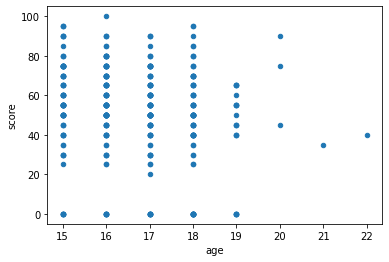

In [17]:
stud.plot(kind='scatter', x='age', y='score')

с полем все ОК 8 значений это от  15 до 22 включительно, 
пропусков и выбросов нет. Лучше сдать до 18 лет, чтобы однозначно не получить  баллов по низу графика. Значит это поле влияет на score

###  address 

 — тип адреса ученика ('U' - городской, 'R' - за городом)

In [18]:
counts(stud.address)

{'len': 395, 'noNaN': 378, 'isNaN': 17, 'nunique': 2}

In [19]:
stud.address = str_to_category(stud.address, 'category')

In [20]:
stud.address.value_counts()

U    295
R     83
Name: address, dtype: int64

<AxesSubplot:xlabel='address', ylabel='score'>

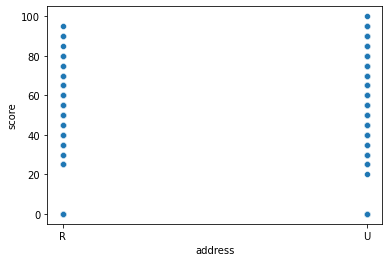

In [21]:
sns.scatterplot(x='address', y='score', data=stud)

Есть пропуски 17 штук, выбросов нет, категориальный тип.  Смотрим по низу - у городских двоек больше, но их больше сдавало экзамен. Представленны данные преимущественно одного типа. 

###   famsize  

  — размер семьи('LE3' <= 3, 'GT3' >3)

In [22]:
counts(stud.famsize)

{'len': 395, 'noNaN': 368, 'isNaN': 27, 'nunique': 2}

In [23]:
stud.famsize = str_to_category(stud.famsize, 'category')

In [24]:
stud.famsize.value_counts()

GT3    261
LE3    107
Name: famsize, dtype: int64

Есть пропуски 27 штук

### поле  Pstatus   

Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

In [25]:
counts(stud.Pstatus)

{'len': 395, 'noNaN': 350, 'isNaN': 45, 'nunique': 2}

In [26]:
stud.Pstatus = stud.Pstatus.astype('category')

In [27]:
stud.Pstatus.value_counts()

T    314
A     36
Name: Pstatus, dtype: int64

У живущих вместе оценки похуже, но их просто гораздо больше. Есть 45 пропусков

### поле  Medu   

Medu — образование матери 
(0 - нет, 1 - 4 класса, 2 - 5-9 классы, 
 3 - среднее специальное или 11 классов, 4 - высшее)

In [28]:
counts(stud.Medu)

{'len': 395, 'noNaN': 392, 'isNaN': 3, 'nunique': 5}

In [29]:
edu_type = CategoricalDtype(categories=[0, 1, 2, 3, 4], ordered=True)

In [30]:
stud.Medu = int_to_category(stud.Medu, edu_type)

In [31]:
stud.Medu.value_counts()

4    131
2    102
3     97
1     59
0      3
Name: Medu, dtype: int64

<AxesSubplot:xlabel='Medu', ylabel='score'>

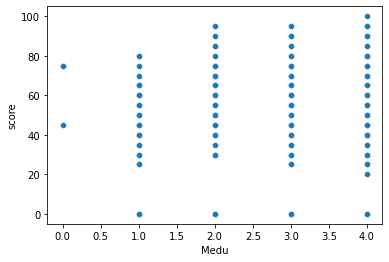

In [32]:
sns.scatterplot(x='Medu', y='score', data=stud)

Категориальный тип, имеется три пропуска, в целом это поле должно влиять 
на оценку, но видимо влияние скрывается за увеличением разброса из-за 
роста количества при повышении уровня образования. 

### поле  Fedu    

Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

In [33]:
counts(stud.Fedu)

{'len': 395, 'noNaN': 371, 'isNaN': 24, 'nunique': 6}

In [34]:
stud.Fedu.value_counts(dropna=False)  # почему 6?

2.0     106
3.0      96
4.0      88
1.0      78
NaN      24
0.0       2
40.0      1
Name: Fedu, dtype: int64

In [35]:
stud[stud.Fedu == 40]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,U,GT3,NaN,2,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


 Посмотрев на остальные данные по строке делаем вывод: значение 40, видимо, обясняется пропуском точки перед нулем, т.к. отец не безработный, является опекуном, имеется семейная образовательная поддержка (Fjob!='at_home', guardian='father', famsup='yes'). Исправим на 4.

In [36]:
stud.replace({'Fedu': 40}, 4, inplace=True)

In [37]:
stud.Fedu = int_to_category(stud.Fedu, edu_type)

In [38]:
stud.Fedu

0      4
1      1
2      1
3      2
4      3
      ..
390    2
391    1
392    1
393    2
394    1
Name: Fedu, Length: 395, dtype: category
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

<AxesSubplot:xlabel='Fedu', ylabel='score'>

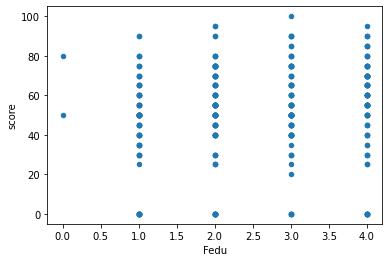

In [39]:
stud.plot(kind='scatter', x='Fedu', y='score')

Категориальный тип, есть 24 пропуска. В целом у отцов образование похуже чем у матерей но это к делу не относится.

### поле  Mjob    

Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [40]:
counts(stud.Mjob)

{'len': 395, 'noNaN': 376, 'isNaN': 19, 'nunique': 5}

In [41]:
stud.Mjob = str_to_category(stud.Mjob, 'category')

<AxesSubplot:xlabel='Mjob', ylabel='score'>

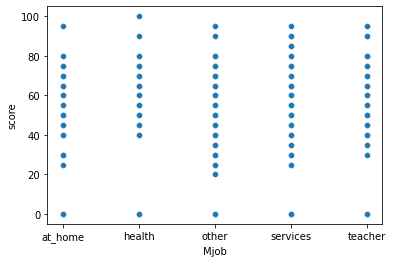

In [42]:
sns.scatterplot(x='Mjob', y='score', data=stud)

категориальный тип, 19 пропусков

### поле  Fjob 

Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [43]:
counts(stud.Fjob)

{'len': 395, 'noNaN': 359, 'isNaN': 36, 'nunique': 5}

In [44]:
stud.Fjob = str_to_category(stud.Fjob, 'category')

In [45]:
stud.Fjob.value_counts()

other       197
services    102
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64

<AxesSubplot:xlabel='Fjob', ylabel='score'>

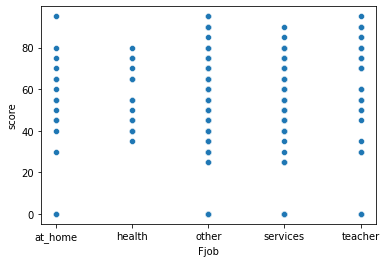

In [46]:
sns.scatterplot(x='Fjob', y='score', data=stud)

категориальный тип, 36 пропусков

### поле  reason   

reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

In [47]:
counts(stud.reason)

{'len': 395, 'noNaN': 378, 'isNaN': 17, 'nunique': 4}

In [48]:
stud.reason = str_to_category(stud.reason, 'category')

In [49]:
stud.reason.value_counts()

course        137
home          104
reputation    103
other          34
Name: reason, dtype: int64

категориальный тип, 17 пропусков

### поле  guardian   

guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

In [50]:
counts(stud.guardian)

{'len': 395, 'noNaN': 364, 'isNaN': 31, 'nunique': 3}

In [51]:
stud.guardian = str_to_category(stud.guardian, 'category')

In [52]:
stud.guardian.value_counts()

mother    250
father     86
other      28
Name: guardian, dtype: int64

категориальный тип, 31 пропуск Поле также представлено однобоко. Чтобы влиять на score данные у отцов и матерей должны как то сильно отличатся, но увидим по boxplot который ниже, что это не так. Значит поле само по себе не пригодно для анализа влияния на score. 

### поле  traveltime   

 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

In [53]:
counts(stud.traveltime)

{'len': 395, 'noNaN': 367, 'isNaN': 28, 'nunique': 4}

In [54]:
time_type = CategoricalDtype(categories=[1, 2, 3, 4], ordered=True)

In [55]:
stud.traveltime = int_to_category(stud.traveltime, time_type)

In [56]:
stud.traveltime.value_counts()

1    242
2     96
3     22
4      7
Name: traveltime, dtype: int64

<AxesSubplot:xlabel='traveltime', ylabel='score'>

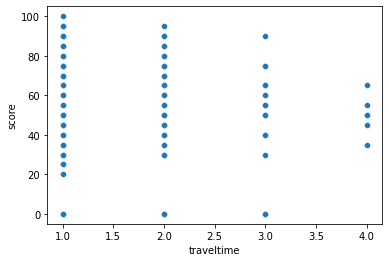

In [57]:
sns.scatterplot(x='traveltime', y='score', data=stud)

Около школы живет много учеников, но также поэтому  и много двоечников, имеется 29 пропусков, категориальный тип данных

### поле  studytime  

studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

In [58]:
counts(stud.studytime)

{'len': 395, 'noNaN': 388, 'isNaN': 7, 'nunique': 4}

In [59]:
stud.studytime = int_to_category(stud.studytime, time_type)

In [60]:
stud.studytime.value_counts()

2    194
1    103
3     64
4     27
Name: studytime, dtype: int64

<AxesSubplot:xlabel='studytime', ylabel='score'>

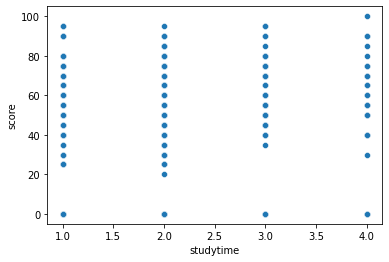

In [61]:
sns.scatterplot(x='studytime', y='score', data=stud)

Номинативные данные, 7 пропусков. По низу графика видно, что данное поле влияет на оценки.

### поле  failures  

 failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

In [62]:
counts(stud.failures)

{'len': 395, 'noNaN': 373, 'isNaN': 22, 'nunique': 4}

In [63]:
failures_type = CategoricalDtype(categories=[0, 1, 2, 3], ordered=True)

In [64]:
stud.failures = int_to_category(stud.failures, failures_type)

<AxesSubplot:xlabel='failures', ylabel='score'>

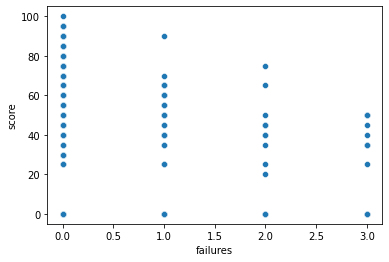

In [65]:
sns.scatterplot(x='failures', y='score', data=stud)

По низу графика заметно, что при большем количестве неудач баллы ниже. Данное поле влияет на оценку.

### поле  schoolsup  

schoolsup — дополнительная образовательная поддержка (yes или no)

In [66]:
counts(stud.schoolsup)

{'len': 395, 'noNaN': 386, 'isNaN': 9, 'nunique': 2}

In [67]:
stud.schoolsup = str_to_category(stud.schoolsup, 'category')

In [68]:
stud.schoolsup.value_counts()

no     335
yes     51
Name: schoolsup, dtype: int64

Хоть данные представленны и однобоко, но по ним поле score сильно различается, что видно по boxplot ниже. Данное поле влияет на оценку

### поле  famsup  

famsup — семейная образовательная поддержка (yes или no)

In [69]:
counts(stud.famsup)

{'len': 395, 'noNaN': 356, 'isNaN': 39, 'nunique': 2}

In [70]:
stud.famsup = str_to_category(stud.famsup, 'category')

In [71]:
stud.famsup.value_counts()

yes    219
no     137
Name: famsup, dtype: int64

### поле  paid  

paid — дополнительные платные занятия по математике (yes или no)

In [72]:
counts(stud.paid)

{'len': 395, 'noNaN': 355, 'isNaN': 40, 'nunique': 2}

In [73]:
stud.paid = str_to_category(stud.paid, 'category')

In [74]:
stud.paid.value_counts()

no     200
yes    155
Name: paid, dtype: int64

<AxesSubplot:xlabel='paid', ylabel='score'>

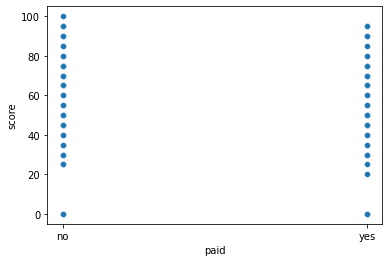

In [75]:
sns.scatterplot(x='paid', y='score', data=stud)

Получается оценка по матетатике не зависит от дополнительных занятий по математике? То же мы видим по boxplot ниже. Странно

### поле  activities  

activities — дополнительные внеучебные занятия (yes или no)

In [76]:
counts(stud.activities)

{'len': 395, 'noNaN': 381, 'isNaN': 14, 'nunique': 2}

In [77]:
stud.activities = str_to_category(stud.activities, 'category')

In [78]:
stud.activities.value_counts()

yes    195
no     186
Name: activities, dtype: int64

### поле  nursery  

nursery — посещал детский сад (yes или no)

In [79]:
counts(stud.nursery)

{'len': 395, 'noNaN': 379, 'isNaN': 16, 'nunique': 2}

In [80]:
stud.nursery = str_to_category(stud.nursery, 'category')

In [81]:
stud.nursery.value_counts()

yes    300
no      79
Name: nursery, dtype: int64

### поле  higher  

higher — хочет получить высшее образование (yes или no)

In [82]:
counts(stud.higher)

{'len': 395, 'noNaN': 375, 'isNaN': 20, 'nunique': 2}

In [83]:
stud.higher = str_to_category(stud.higher, 'category')

In [84]:
stud.higher.value_counts()

yes    356
no      19
Name: higher, dtype: int64

Данные в этом поле также однобокие, для оценки влияния не годятся. Все хотят в вуз.

### поле  internet  

internet — наличие интернета дома (yes или no)

In [85]:
counts(stud.internet)

{'len': 395, 'noNaN': 361, 'isNaN': 34, 'nunique': 2}

In [86]:
stud.internet = str_to_category(stud.internet, 'category')

In [87]:
stud.internet.value_counts()

yes    305
no      56
Name: internet, dtype: int64

### поле  romantic  

romantic — в романтических отношениях (yes или no)

In [88]:
counts(stud.romantic)

{'len': 395, 'noNaN': 364, 'isNaN': 31, 'nunique': 2}

In [89]:
stud.romantic = str_to_category(stud.romantic, 'category')

In [90]:
stud.romantic.value_counts()

no     240
yes    124
Name: romantic, dtype: int64

### поле  famrel 

famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

In [91]:
counts(stud.famrel)

{'len': 395, 'noNaN': 368, 'isNaN': 27, 'nunique': 6}

In [92]:
stud.famrel.value_counts()  # почему 6 значений? Как же они плохо живут  всемье :-)

 4.0    182
 5.0     99
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

In [93]:
ind = stud.famrel[stud.famrel == -1].index
stud.loc[ind]     # Имеется значение -1

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,GP,F,16,U,GT3,NaN,2,2,services,services,home,mother,1,1,2,no,yes,yes,no,no,-3.0,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0


(Pstatus=='NaN', guardian=='mother') из данных мы не можем решить, 
 на что заменить -1. Удалим его!

In [94]:
stud.replace({'famrel': -1}, np.nan, inplace=True)

In [95]:
stud.famrel.value_counts() # Они очень плохо живут в семье? Или это подростки не ладят с родителями?

4.0    182
5.0     99
3.0     62
2.0     17
1.0      7
Name: famrel, dtype: int64

In [96]:
eval_type = CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True)
# Оценочный тип, для оценки от 1 до 5

In [97]:
stud.famrel = int_to_category(stud.famrel, eval_type)

### поле  freetime  

 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

In [98]:
counts(stud.freetime)

{'len': 395, 'noNaN': 384, 'isNaN': 11, 'nunique': 5}

In [99]:
stud.freetime = int_to_category(stud.freetime, eval_type)

In [100]:
stud.freetime.value_counts()

3    153
4    112
2     63
5     38
1     18
Name: freetime, dtype: int64

### поле  goout  

goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

In [101]:
counts(stud.goout)

{'len': 395, 'noNaN': 387, 'isNaN': 8, 'nunique': 5}

In [102]:
stud.goout = int_to_category(stud.goout, eval_type)

In [103]:
stud.goout.value_counts()

3    127
2    101
4     84
5     52
1     23
Name: goout, dtype: int64

<AxesSubplot:xlabel='goout', ylabel='score'>

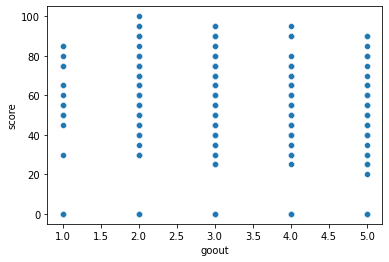

In [104]:
sns.scatterplot(x='goout', y='score', data=stud)

### поле  health  

health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

In [105]:
counts(stud.health)

{'len': 395, 'noNaN': 380, 'isNaN': 15, 'nunique': 5}

In [106]:
stud.health = int_to_category(stud.health, eval_type)

In [107]:
stud.health.value_counts()

5    138
3     89
4     63
1     47
2     43
Name: health, dtype: int64

### поле  absences  

absences — количество пропущенных занятий

In [108]:
counts(stud.absences)

{'len': 395, 'noNaN': 383, 'isNaN': 12, 'nunique': 36}

In [109]:
stat(stud.absences)

{'mean': 7.2794, 'median': 4.0, 'perc25': 0.0, 'perc75': 8.0, 'IQR': 8.0}

In [110]:
min_max(stud.absences, 10)

{'min': 0.0,
 'max': 385.0,
 'n_max': 222    385.0
 390    212.0
 276     75.0
 183     56.0
 74      54.0
 315     40.0
 307     38.0
 280     30.0
 205     28.0
 103     26.0
 Name: absences, dtype: float64}

In [111]:
ind1 = stud.absences[stud.absences == 385.0].index
ind2 = stud.absences[stud.absences == 212.0].index

In [112]:
stud.loc[ind1]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
222,GP,F,16,U,GT3,T,2,3,services,teacher,other,mother,1,2,0,yes,NaN,no,no,yes,-6.0,yes,yes,no,2,3,1,3,385.0,85.0


Девушка 16 лет, родители живут вместе, отец учитель со средним специальным 
образованием, хочет поступить в ВУЗ, но школу выбрала по иной причине, 
не из-за близости к дому, хотя она и близко. После школы много времени,
здоровье хорошее, баллы по математике высокие. Почему много пропусков? 
Даже если не ошибка, то, вероятно, отец учитель математики в той же школе. 
Это нестандартное значение повлияет на результат, лучше заменим  на NaN.


In [113]:
stud.loc[ind2]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
390,MS,M,20,U,LE3,A,2,2,services,services,course,NaN,1,2,2,no,yes,yes,no,yes,-6.0,yes,no,no,5,5,4,4,212.0,45.0


Парень 20 лет, здоровье хорошее, родители оба госслужащие с 9 классов 
образования??! разведены, школа выбрана из-за образов. прграммы, помимо учебы
есть доп занятия, хочет поступать в ВУЗ, много свободного времени.
Вывод сделать сложно, показатель сильно выбивается, лучше заменим на NaN

In [114]:
stud.loc[ind1, 'absences'] = np.nan

In [115]:
stud.loc[ind2, 'absences'] = np.nan

<AxesSubplot:xlabel='absences', ylabel='score'>

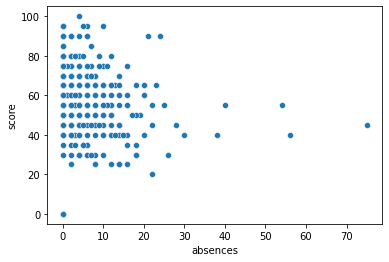

In [116]:
sns.scatterplot(x='absences', y='score', data=stud)

<AxesSubplot:>

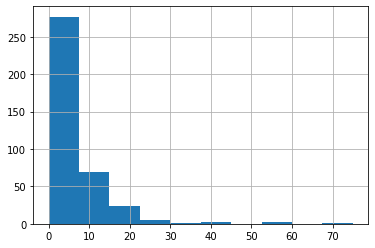

In [117]:
stud.absences.hist()

Пробовал данное поле логарифмировать, чтобы привести к нормальному распределению. Но как показал sns.pairplot и stud.corr() ни на что это не повлияло. Поэтому я это все удалил, чтобы не загромождать

### поле  score  

score — баллы по госэкзамену по математике

In [118]:
counts(stud.score)

{'len': 395, 'noNaN': 389, 'isNaN': 6, 'nunique': 18}

<AxesSubplot:>

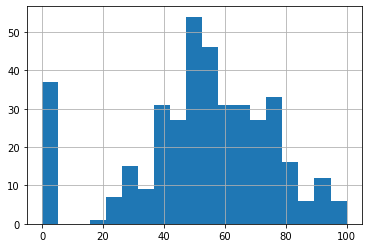

In [119]:
stud.score.hist(bins=19)

In [120]:
stud.corr()

,age,"studytime, granular",absences,score
age,1.000000,0.015556,0.166773,-0.155726
"studytime, granular",0.015556,1.000000,0.067734,-0.115741
absences,0.166773,0.067734,1.000000,0.031698
score,-0.155726,-0.115741,0.031698,1.000000


В score много нулей, наверное это не оценки, а те, кто не сдавал экзамен. Это будут выбросы. Уберем их. Остальные оценки от 20 до 100 вполне реальные. Я заменял пропуски score средним, но это ни на что не повлияло, поэтому я это убрал, чтобы не загромождать анализ.

In [121]:
stud.replace({'score': 0}, np.nan, inplace=True)

In [122]:
counts(stud.score)

{'len': 395, 'noNaN': 352, 'isNaN': 43, 'nunique': 17}

In [123]:
stud.corr()

,age,"studytime, granular",absences,score
age,1.000000,0.015556,0.166773,-0.131542
"studytime, granular",0.015556,1.000000,0.067734,-0.142055
absences,0.166773,0.067734,1.000000,-0.214926
score,-0.131542,-0.142055,-0.214926,1.000000


После удаления нулей изменилась и стала  отрицательной связь score с absences с 0.031698 до -0.214926 и это правильно:
больше пропусков - меньше балл. Кроме того распределение становится похоже на нормальное, теперь можно применить тест Стьюдента

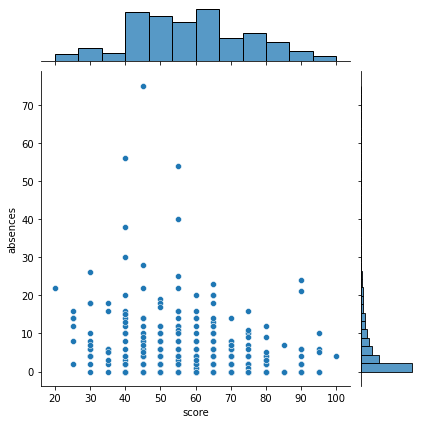

In [124]:
sns.jointplot(x=stud['score'], y=stud['absences'])

 ## В итоге упорядочивания данных мы получили таблицу:

In [125]:
stud.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,-6.0,yes,NaN,no,4,3,4,3,6.0,30.0
1,GP,F,17,U,GT3,NaN,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,-6.0,yes,yes,no,5,3,3,3,4.0,30.0
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4,3,2,3,10.0,50.0
3,GP,F,15,U,GT3,T,4,2,health,NaN,home,mother,1,3,0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3,2,2,5,2.0,75.0
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,-6.0,yes,no,no,4,3,2,5,4.0,50.0


In [126]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   school               395 non-null    category
 1   sex                  395 non-null    category
 2   age                  395 non-null    int64   
 3   address              378 non-null    category
 4   famsize              368 non-null    category
 5   Pstatus              350 non-null    category
 6   Medu                 392 non-null    category
 7   Fedu                 371 non-null    category
 8   Mjob                 376 non-null    category
 9   Fjob                 359 non-null    category
 10  reason               378 non-null    category
 11  guardian             364 non-null    category
 12  traveltime           367 non-null    category
 13  studytime            388 non-null    category
 14  failures             373 non-null    category
 15  schoolsup            38

# Анализ числовых данных

<AxesSubplot:xlabel='studytime, granular', ylabel='studytime'>

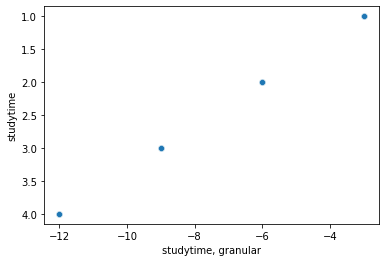

In [127]:
sns.scatterplot(x=stud['studytime, granular'], y=stud['studytime'])

Наблюдаем полную корреляцию, 'studytime, granular' нужно удалить это поле дублирует поле studytime

In [128]:
# Разберем столбцы по типам 
# 1. числовые столбцы
numerical = ['age',  'absences', 'score'] 

# 2. cемейные ценности
family = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
          'Mjob', 'Fjob', 'guardian', 'famrel']

# 3. столбцы времени
time = ['traveltime', 'studytime', 'freetime', 'goout']

# 4. остальное
other = ['reason', 'failures', 'schoolsup', 'famsup',  'paid', 'activities',
         'nursery', 'higher', 'internet', 'romantic', 'health']

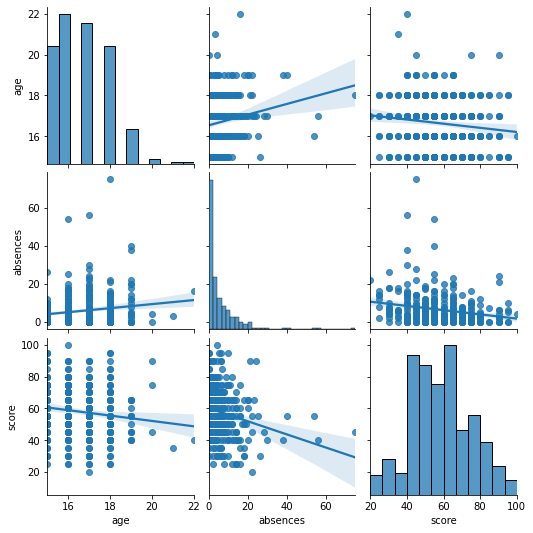

In [129]:
sns.pairplot(stud[numerical], kind='reg') # посмотрим на числовые столбцы

Вывод: числовые данные 'age',  'absences' связаны и коррелируют  со 'score'

# Анализ категориальных переменных

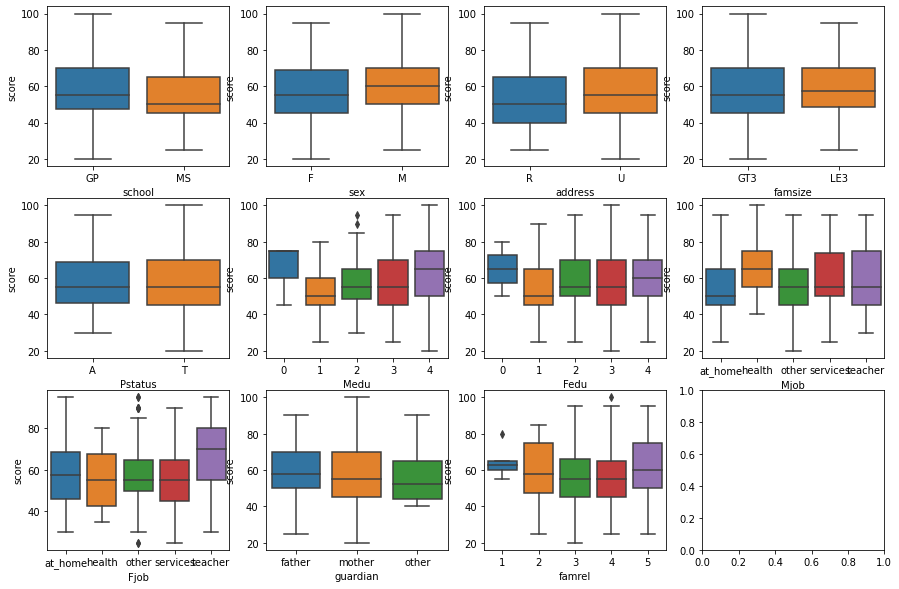

In [130]:
#Семейные ценности
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
for var, subplot in zip(family, ax.flatten()):
    sns.boxplot(x=var, y='score', data=stud, ax=subplot)

Не влияющие на оценку колонки: school, Pstatus, famsize.  
А Medu и  Fedu, Mjob и Fjob хочется сложить между собой

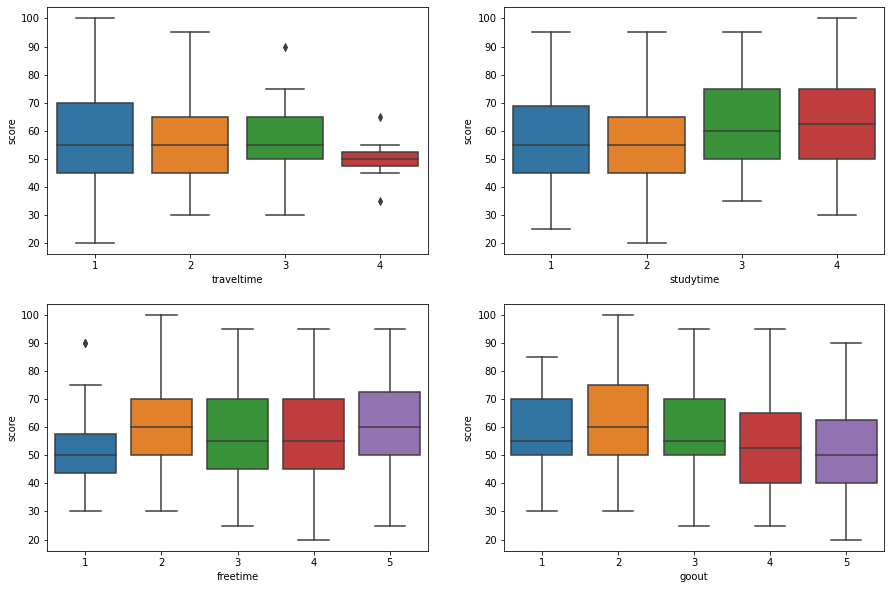

In [131]:
# Временные колонки
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for var, subplot in zip(time, ax.flatten()):
    sns.boxplot(x=var, y='score', data=stud, ax=subplot)

Не влияющие на оценку колонки: traveltime.

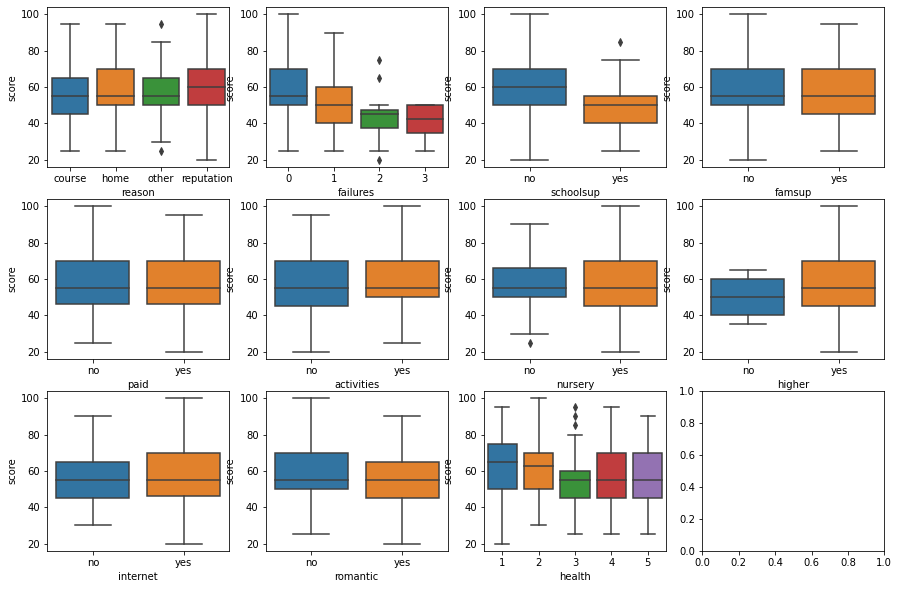

In [132]:
# Остальные колонки
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
for var, subplot in zip(other, ax.flatten()):
    sns.boxplot(x=var, y='score', data=stud, ax=subplot)

Не влияющие на оценку колонки: famsup, internet, nursery, paid, activities

Применим копипаст с курсов с тестом Стюдента без учета NaN. 
Нулевая гипотеза гласит, что оценки по различным номинативным переменным не различаются.

In [133]:
def get_stat_dif(column):
# функция из курсов выполняет парный тест Стьюдента с 95% уровнем довения 
    cols = stud.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud.loc[stud.loc[:, column] == comb[0], 'score'],
                     stud.loc[stud.loc[:, column] == comb[1], 'score'], nan_policy='omit').pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [134]:
for col in family:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Fedu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки Fjob


In [135]:
for col in time:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки goout


In [136]:
for col in other:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки schoolsup


## Пребразуем данные

Увидел в интернете, что даже колонка не показывающая своего влияния на целевую переменную может в комбинации с другими выдать явную связь. Попробую найти.

Идея 1: Сложим рейтинги образования матери Medu и  отца Fedu вместе, при этом к слагаемому применим коэффициент 2, соответствующий опекуну - guardian

In [137]:
def guardian_m(x):
    # определение веса, для образования матери: если опекун мать, то 2, иначе 1
    if x == "mother":
        return 2
    else:
        return 1


def guardian_f(x):
    # определение веса, для образования отца: если опекун отец, то 2, иначе 1
    if x == "father":
        return 2
    else:
        return 1

Новое поле 'edu'

In [138]:
stud['edu']=[guardian_m(stud.loc[idx, 'guardian']) * stud.loc[idx,'Medu'] + \
             guardian_f(stud.loc[idx, 'guardian']) * stud.loc[idx,'Fedu'] for  idx in range(len(stud))]

In [139]:
counts(stud.edu)

{'len': 395, 'noNaN': 368, 'isNaN': 27, 'nunique': 12}

<AxesSubplot:xlabel='score', ylabel='edu'>

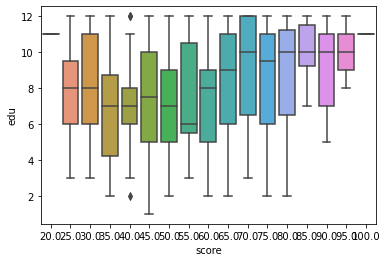

In [140]:
sns.boxplot(x='score', y='edu', data=stud)

Сработало! Наблюдаем влияние поля edu на поле score

Идея 2: сложить Mjob  & Fjob в поле job c учетом влияния опекуна guardian.  

In [141]:
def guardian_job(guardian, m_job, f_job):
    # сложение полей с учетом того, кто является опекуном
    if (guardian == "mother") and (m_job == m_job): return m_job # опекун -  мать и поле не NaN 
    elif (guardian == "father") and (f_job == f_job): return f_job #опекун -  отец и поле не NaN
    elif m_job != m_job: return f_job #поле Mjob -  NaN
    elif f_job != f_job: return m_job #поле Fjob -  NaN
    else: return m_job

In [142]:
stud['job']=[guardian_job(stud.loc[idx, 'guardian'], stud.loc[idx, 'Mjob'], stud.loc[idx, 'Fjob']) 
             for  idx in range(len(stud))]

In [143]:
counts(stud.job)

{'len': 395, 'noNaN': 394, 'isNaN': 1, 'nunique': 5}

<AxesSubplot:xlabel='score', ylabel='job'>

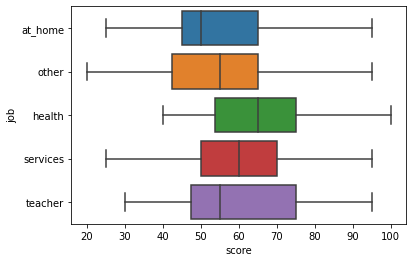

In [144]:
sns.boxplot(x='score', y='job', data=stud)

Смешно - самые отъявленные двоечники это дети учителей. А если не хочешь два по математике,  то имей родителей  врачей.

Идея не удачная, т.к. то же самое и еще более явно просматривается из boxplot выше и два явно влияющих поля наверно лучше чем одно, влияющее посредственно. 

Идея 3: При невысоком уровне достатка в стране, если статус проживания родителей 'раздельно' и семья больше 3, то значит один родитель, и много детей - это плохо, а если статус проживания 'вместе' и семья меньше трех, то два родителя и один ребенок  - это хорошо

Идея также не сработала, влияния не обнаружено поэтому я удалил строки, чтобы не замусоривать ноутбук

Идея 4: Самая первая и бесполезная назначать веса категориальным переменным и считать баллы

In [145]:
# веса
o1 = -1  # schoolsup странно, по боксплотам выше: есть школьная поддержка - меньше балл. Может поддержка предназначена для двоечников
o2 = 0  # famsup Согласно боксплотам не влияет на оценку
o3 = 0  # paid Согласно боксплотам не влияет на оценку
o4 = 1  # activities Согласно боксплотам не влияет на оценку
o5 = 1  # higher
o6 = -1  # failures
o7 = -1  # romantic

In [146]:
def yes_to1(x):
    # функция для превращения 'yes' в 1
    if x == "yes":
        return 1
    else:
        return 0

In [147]:
stud['other_score'] = [o1*yes_to1(stud.loc[idx, 'schoolsup']) + o2*yes_to1(stud.loc[idx, 'famsup']) +
                       o3*yes_to1(stud.loc[idx, 'paid']) + o4*yes_to1(stud.loc[idx, 'activities']) +
                       o5*yes_to1(stud.loc[idx, 'higher']) + o6*yes_to1(stud.loc[idx, 'failures']) +
                       o7*yes_to1(stud.loc[idx, 'romantic']) for idx in range(len(stud))]

In [148]:
numerical1 = ['absences', 'score','other_score']

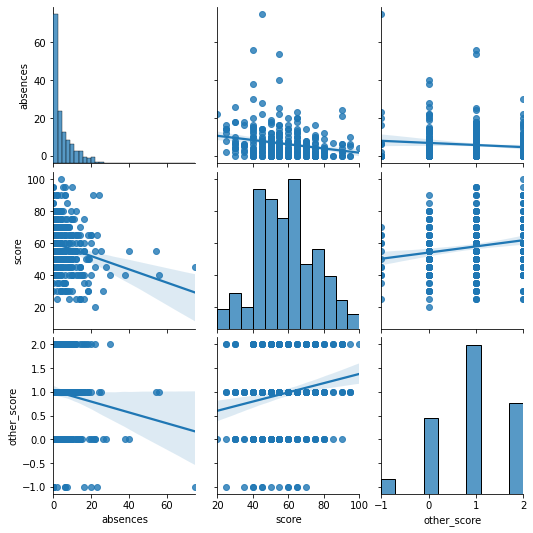

In [149]:
sns.pairplot(stud[numerical1], kind='reg')

Заметна слабая положительная корреляция по полям score и придуманным баллам. Наверно это  показывает  влияние полей, из которых  собраны баллы, но кажется это просто примитивная реализация boxplot. 

### По итогам анализа я бы оставил эти колонки как влияющие на баллы по экзамену:

In [150]:
col = ['age', 'address', 'edu', 'Mjob', 'Fjob', 'studytime', 'failures',
       'schoolsup', 'higher', 'famrel',  'freetime', 'goout', 'absences', 'score']

In [151]:
stud_for_model = stud.loc[:, col]

In [152]:
stud_for_model.head()

,age,address,edu,Mjob,Fjob,studytime,failures,schoolsup,higher,famrel,freetime,goout,absences,score
0,18,U,12.0,at_home,teacher,2,0,yes,yes,4,3,4,6.0,30.0
1,17,U,3.0,at_home,other,2,0,no,yes,5,3,3,4.0,30.0
2,15,U,3.0,at_home,other,2,3,yes,yes,4,3,2,10.0,50.0
3,15,U,10.0,health,NaN,3,0,no,yes,3,2,2,2.0,75.0
4,16,U,9.0,other,other,2,0,no,yes,4,3,2,4.0,50.0


 ### Найдем число пропусков

In [153]:
null_count={}
for i in col:
    null_count[i]=stud_for_model[i].isnull().sum()
null_count    
    

{'age': 0,
 'address': 17,
 'edu': 27,
 'Mjob': 19,
 'Fjob': 36,
 'studytime': 7,
 'failures': 22,
 'schoolsup': 9,
 'higher': 20,
 'famrel': 28,
 'freetime': 11,
 'goout': 8,
 'absences': 14,
 'score': 43}